<a href="https://colab.research.google.com/github/EgeSarii/Reinforcement-Learning/blob/branch_ege/4-MC-assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Reinforcement Learning 4: *Monte Carlo Methods*

**Assignment:** hand-in before 07/03/2022.

In this week's assignment, you are going to use Monte Carlo methods to play BlackJack. Remember the task description from the lecture (see also course textbook, Example 5.1).

![](https://drive.google.com/uc?id=1R2-H6ra4BqFMJK752OAUNLaKia233V2o)

In [1]:
import sys
import gym
import numpy as np
from tqdm import tqdm
from collections import defaultdict
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

Let's first prepare the visualizations required for the task:

In [2]:
def plot_blackjack_values(V):
    def get_Z(x, y, usable_ace):
        if (x,y,usable_ace) in V:
            return V[x,y,usable_ace]
        else:
            return 0
    def get_figure(usable_ace, ax):
        x_range = np.arange(11, 22)
        y_range = np.arange(1, 11)
        X, Y = np.meshgrid(x_range, y_range)
        Z = np.array([get_Z(x,y,usable_ace) for x,y in zip(np.ravel(X), np.ravel(Y))]).reshape(X.shape)
        surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=plt.cm.coolwarm, vmin=-1.0, vmax=1.0)
        ax.set_xlabel('Player\'s Current Sum')
        ax.set_ylabel('Dealer\'s Showing Card')
        ax.set_zlabel('State Value')
        ax.view_init(ax.elev, -120)

    fig = plt.figure(figsize=(20, 20))
    ax = fig.add_subplot(211, projection='3d')
    ax.set_title('Usable Ace')
    get_figure(True, ax)
    ax = fig.add_subplot(212, projection='3d')
    ax.set_title('No Usable Ace')
    get_figure(False, ax)
    plt.show()

def plot_policy(policy):
    def get_Z(x, y, usable_ace):
        if (x,y,usable_ace) in policy:
            return policy[x,y,usable_ace]
        else:
            return 1
    def get_figure(usable_ace, ax):
        x_range = np.arange(11, 22)
        y_range = np.arange(10, 0, -1)
        X, Y = np.meshgrid(x_range, y_range)
        Z = np.array([[get_Z(x,y,usable_ace) for x in x_range] for y in y_range])
        surf = ax.imshow(Z, cmap=plt.get_cmap('Pastel2', 2), vmin=0, vmax=1, extent=[10.5, 21.5, 0.5, 10.5])
        plt.xticks(x_range)
        plt.yticks(y_range)
        plt.gca().invert_yaxis()
        ax.set_xlabel('Player\'s Current Sum')
        ax.set_ylabel('Dealer\'s Showing Card')
        ax.grid(color='w', linestyle='-', linewidth=1)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.1)
        cbar = plt.colorbar(surf, ticks=[0,1], cax=cax)
        cbar.ax.set_yticklabels(['0 (STICK)','1 (HIT)'])
    fig = plt.figure(figsize=(15, 15))
    ax = fig.add_subplot(121)
    ax.set_title('Usable Ace')
    get_figure(True, ax)
    ax = fig.add_subplot(122)
    ax.set_title('No Usable Ace')
    get_figure(False, ax)
    plt.show()

**a**) Load and explore the `Blackjack-v1` environment:

*(0.5 Points)*

In [3]:
env = gym.make('Blackjack-v0')

Note that each state is a 3-tuple of:
- the player's current sum $\in \{0, 1, ..., 31\}$
- the dealer's face up card, $\in \{1, ..., 10\}$
- whether or not the player has a usable ace (no$=0$, yes$=1$).

The agent has two potential actions:
- STICK = 0
- HIT = 1

The return is only computed at the end of an episode:
- Loose = -1
- Tie = 0
- Win = 1

**b**) Run 10 episodes with a random policy.
*(0.5 Points)*

In [4]:
def play_episode(env, display=True):
    episode = []
    rewards = []
    state = env.reset()
    action_name = ["STICK", "HIT"]
    while True:
        action = env.action_space.sample()
        next_state, reward, done, info = env.step(action)

        if display:
            print("Initial state:", state)
            print("Player: ",env.player)
            print("Dealer: ",env.dealer)
            print(action_name[action])
            print("Current state:", next_state)

        episode.append((state, action, reward))
        state = next_state
        if done:
            rewards.append(reward)
            if display:
                print("Player: ",env.player)
                print("Dealer: ",env.dealer)
                print("Reward:", reward)
            break
    return episode, rewards

In [5]:
n_episodes = 10
rw = []
for ep in range(n_episodes):
    ep, rwe = play_episode(env)
    rw.append(rwe[0])
print("Win: ",np.sum([t for t in rw if t > 0])/n_episodes*100,"%")
print("Tie: ",np.sum([t for t in rw if t == 0])/n_episodes*100,"%")
print("Lost: ",np.sum([t*-1 for t in rw if t < 0])/n_episodes*100,"%")

Initial state: (19, 5, False)
Player:  [9, 10, 9]
Dealer:  [5, 6]
HIT
Current state: (28, 5, False)
Player:  [9, 10, 9]
Dealer:  [5, 6]
Reward: -1.0
Initial state: (12, 9, False)
Player:  [4, 8]
Dealer:  [9, 8]
STICK
Current state: (12, 9, False)
Player:  [4, 8]
Dealer:  [9, 8]
Reward: -1.0
Initial state: (21, 10, True)
Player:  [1, 10]
Dealer:  [10, 3, 9]
STICK
Current state: (21, 10, True)
Player:  [1, 10]
Dealer:  [10, 3, 9]
Reward: 1.0
Initial state: (6, 3, False)
Player:  [3, 3, 3]
Dealer:  [3, 4]
HIT
Current state: (9, 3, False)
Initial state: (9, 3, False)
Player:  [3, 3, 3]
Dealer:  [3, 4, 9, 1]
STICK
Current state: (9, 3, False)
Player:  [3, 3, 3]
Dealer:  [3, 4, 9, 1]
Reward: -1.0
Initial state: (12, 4, False)
Player:  [5, 7, 4]
Dealer:  [4, 9]
HIT
Current state: (16, 4, False)
Initial state: (16, 4, False)
Player:  [5, 7, 4, 6]
Dealer:  [4, 9]
HIT
Current state: (22, 4, False)
Player:  [5, 7, 4, 6]
Dealer:  [4, 9]
Reward: -1.0
Initial state: (14, 3, False)
Player:  [4, 10, 7

**c**) **MC prediction**: Apply the first-visit MC prediction algorithms with Exploring Starts (ES) to estimate the action-value function, $q_{\pi}(s, a)$ and calculate the value of an initial, random policy.

*(3 Points)*

In [6]:
def update_Q(episode, Q, returns_sum, N, gamma=1.0):
    """
    For each time step in the episode we carry out the first visit monte carlo method with exploring starts, 
    checking if this is the first index of this state. Get the discounted reward and add it to the total reward 
    for that state/action pair. Increment the times we have seen this state action pair and finally update the Q values
    """
    for s, a, r in episode:
        first_occurence_idx = next(i for i, x in enumerate(episode) if x[0] == s)
        G = sum([x[2] * (gamma ** i) for i, x in enumerate(episode[first_occurence_idx:])])
        returns_sum[s][a] += G
        N[s][a] += 1.0
        Q[s][a] = returns_sum[s][a] / N[s][a]

In [7]:
def mc_predict(env, num_episodes, gamma=1.0):
    """
    This is the primary method. Plays through several episodes of the environment.
    """
    #Initializations
    returns_sum = defaultdict(lambda: np.zeros(env.action_space.n))
    N = defaultdict(lambda: np.zeros(env.action_space.n))
    Q = defaultdict(lambda: np.zeros(env.action_space.n))

    for i_episode in tqdm(range(1, num_episodes+1)):
        episode, _ = play_episode(env, False)
        update_Q(episode, Q, returns_sum, N, gamma)

    return Q

100%|██████████| 100000/100000 [00:13<00:00, 7625.00it/s]


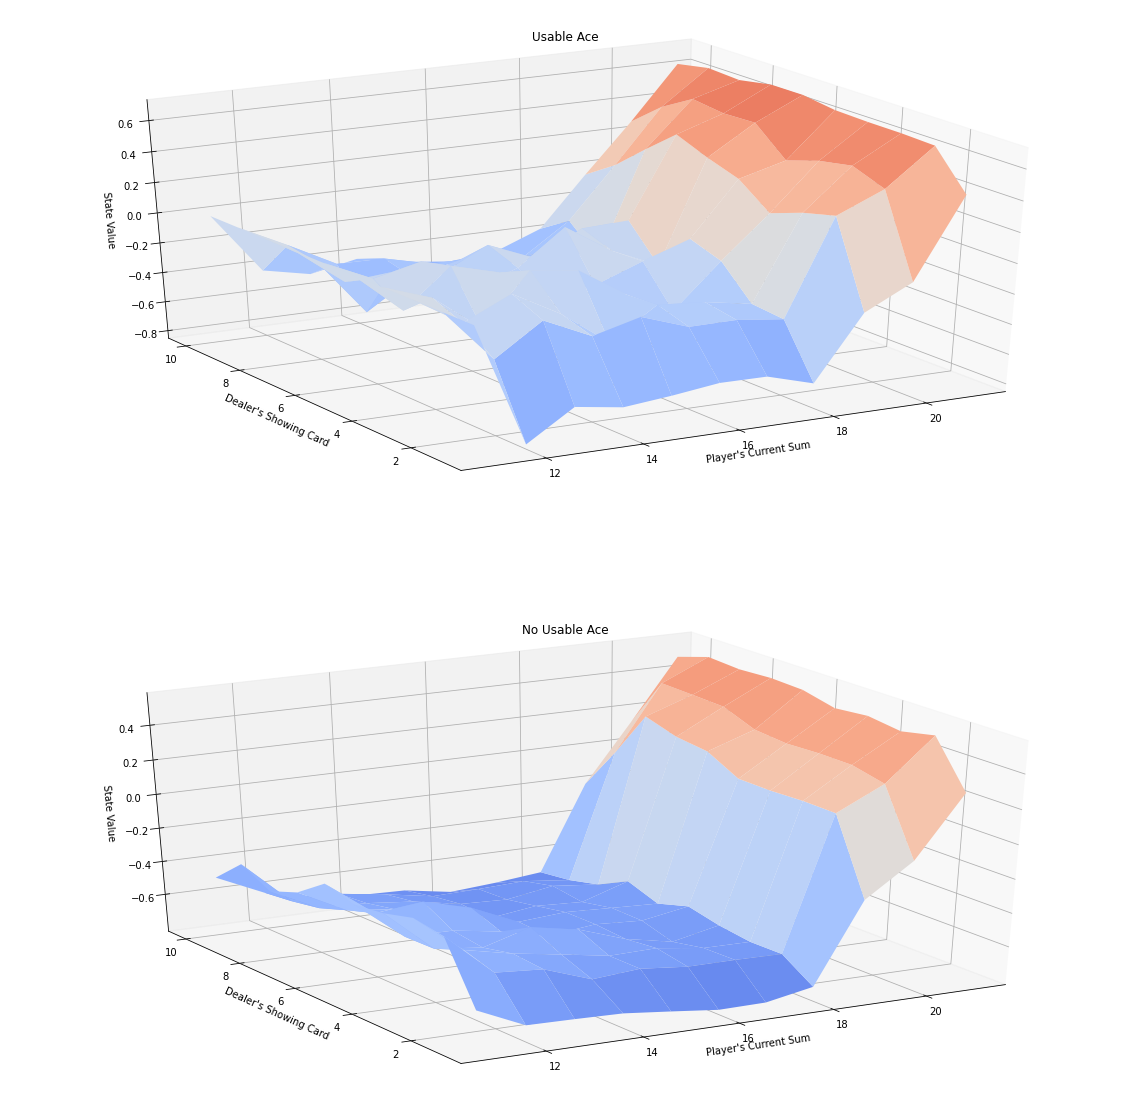

In [8]:
# predict the policy values for our random policy, over a large number of episodes
sample_episodes = 100000
Q = mc_predict(env, sample_episodes)

# get the state value function for our test policy
V_to_plot = dict((k,(k[0]>18)*(np.dot([0.8, 0.2],v)) + (k[0]<=18)*(np.dot([0.2, 0.8],v)))
                 for k, v in Q.items())

# plot the state value functions
plot_blackjack_values(V_to_plot)

**d**) **MC control**: Using the methods above to compute the action-value function, $q_{\pi}(s, a)$, optimize the policy. Use on-policy MC control with $\epsilon$-greedy action selection.

*(5 Points)*

In [9]:
def get_probs(Q_s, epsilon, nA):
    """
    Get the probability of taking the best known action according to epsilon (epsilon-greedy).
    Returns the policy for the Q value given
    """
    policy_s = np.ones(nA) * epsilon / nA # non-greedy actions
    best_a = np.argmax(Q_s)
    policy_s[best_a] = 1 - epsilon + (epsilon /nA)# greedy actions
    return policy_s

In [10]:
def best_policy(Q, nA):
    """
    returns the best actions for each Q value in the policy
    """
    return dict((k,np.argmax(v)) for k, v in Q.items())

In [11]:
def update_Q(env, episode, Q, alpha, gamma):
    """
    Calculate the new Q values for the actions taken in the given episode.
    Returns the new Q value function
    """
    for s, a, r in episode:
        first_occurence_idx = next(i for i,x in enumerate(episode) if x[0] == s)
        G = sum([x[2]*(gamma**i) for i,x in enumerate(episode[first_occurence_idx:])])
        Q[s][a] = Q[s][a] + alpha*(G - Q[s][a])

    return Q

In [12]:
def play_game(env, Q, epsilon, nA):
    """
    generates an episode from following the epsilon-greedy policy containing the state, action and reward for
    each time step in the episode.
    Returns all step information for that episode
    """
    episode = []
    state = env.reset()
    while True:
        probs = get_probs(Q[state], epsilon, nA)
        action = np.random.choice(np.arange(nA), p=probs) if state in Q else env.action_space.sample()
        state, reward, done, info = env.step(action)
        episode.append((state, action, reward))
        if done:
            break
    return episode

In [14]:
def mc_control(env, num_episodes):
    """
    main method. Iterates through episodes updating epsilon after each, retrieves the list of states, actions
    and rewards from the last episode and use them to calculate the updated Q values
    """
    epsilon = 1.0
    eps_min = 0.01
    decay = 0.9999
    alpha = 0.001
    gamma = 1.0

    nA = env.action_space.n
    Q = defaultdict(lambda: np.zeros(nA))
    for i_episode in tqdm(range(1, num_episodes+1)):
        epsilon = max(epsilon*decay, eps_min)
        episode = play_game(env,Q,epsilon,nA)
        Q = update_Q(env, episode, Q, alpha, gamma)
        A_star = best_policy(Q, nA)
        policy_star = get_probs(Q, epsilon,nA) 
    policy = policy_star
    return policy, Q

100%|██████████| 500000/500000 [07:40<00:00, 1086.67it/s]


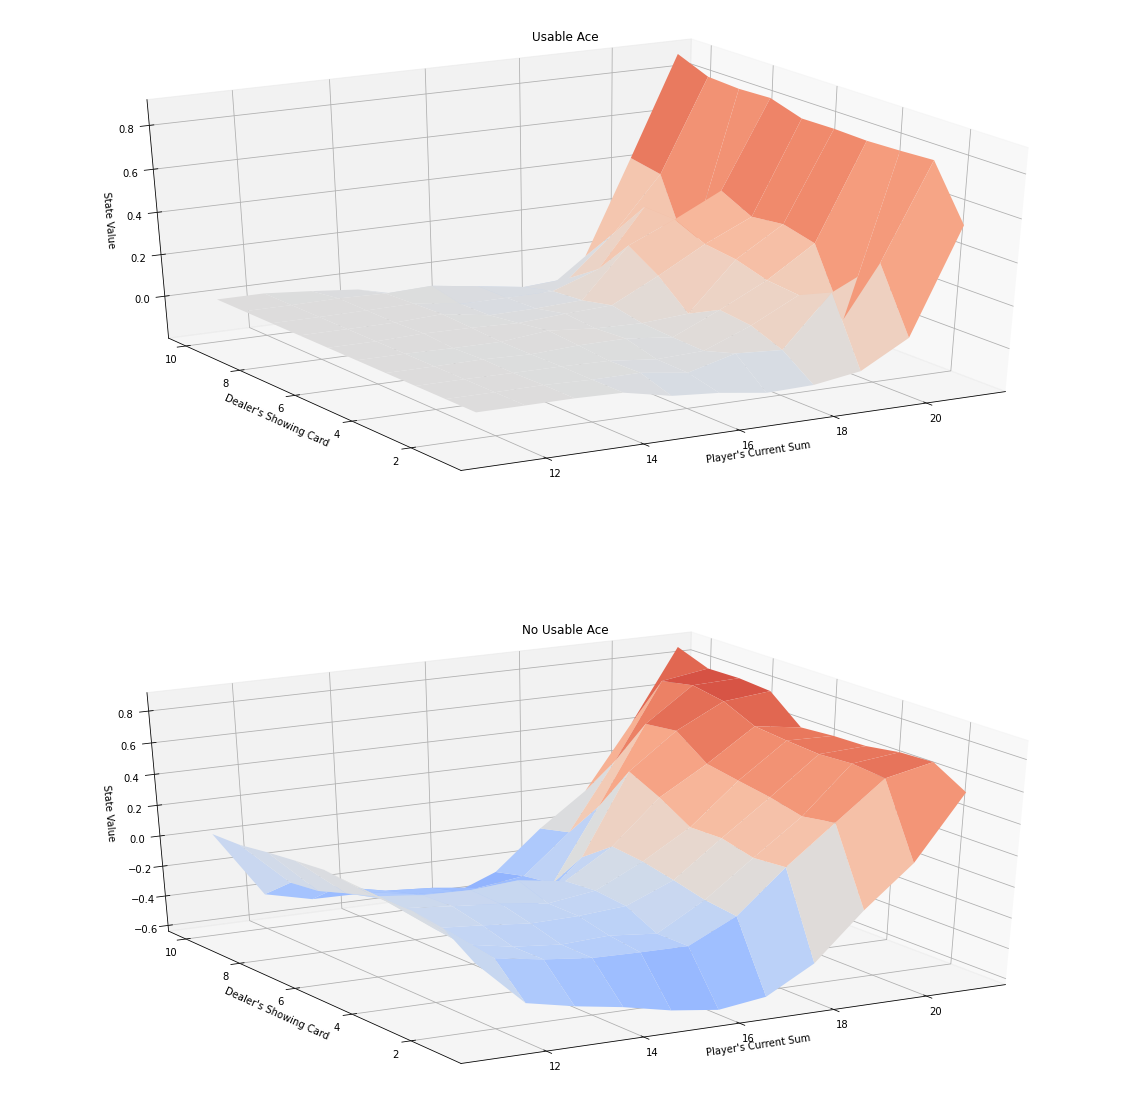

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


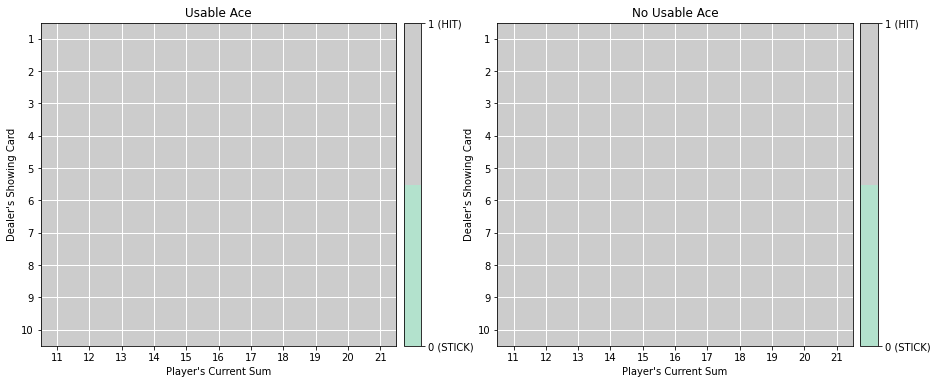

In [15]:
n_episodes = 500000
policy, Q = mc_control(env, n_episodes)
V = dict((k,np.max(v)) for k, v in Q.items())

plot_blackjack_values(V)
plot_policy(policy)

**e**) **Sample efficiency**. MC methods require hundreds of thousands of sample episodes to converge. Study how the number of samples affects the learned value functions and policies.

*(1 Point)*